In [1]:
import numpy as np
import qiskit as qis

from numpy.random import default_rng

from qiskit.exceptions import QiskitError
from qiskit.quantum_info.operators.random import * 
from qiskit_aer.backends import AerSimulator
from qiskit.quantum_info import *
from qiskit.primitives import Sampler

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error, amplitude_damping_error)
#from qiskit.extensions import Initialize

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Botond\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Quantum circuits and entanglement in action

In computer science, circuits are models of computation in which information is carried by wires through a network of gates, which represent operations that transform the information carried by the wires. Quantum circuits are just one example of a model of computation based on this more general concept.

In the quantum model the wires represent qubits, and the gates represent quantum operations. Quantum circuits can be used to create quantum algorithms, simulate quantum systems, and even perform quantum computations.

Below I will how to represent a simple quantum circuit using Qiskit.

In [2]:
from qiskit.quantum_info import Operator

X = Operator([[0, 1], [1, 0]])
Y = Operator([[0, -1.0j], [1.0j, 0]])
Z = Operator([[1, 0], [0, -1]])
H = Operator([[1 / sqrt(2), 1 / sqrt(2)], [1 / sqrt(2), -1 / sqrt(2)]])
S = Operator([[1, 0], [0, 1.0j]])
T = Operator([[1, 0], [0, (1 + 1.0j) / sqrt(2)]])   #evolving operators

v = Statevector([1, 0]) #statevector for |0>

#we let the state evolve as the Schrodinger equation evolves it --> U(t) = exp(-i*H*t/hbar) 
v = v.evolve(H)
v = v.evolve(Z)
v = v.evolve(H) #in our case it is just U(t)|v(0)> = |v(t)> where U(t) is the continous application of the operators

v.draw("text")

[0.+0.j,1.+0.j]

We see that the application of a Hadamard gate (H) followed by a Z gate (Z) and then a Hadamard gate (H) again will transform the state:
\begin{equation}
    (H Z H) \ket{0} = (H Z) \ket{+} = (H) \ket{-} = \ket{1}
\end{equation}

Now show this as a simple circuit below.

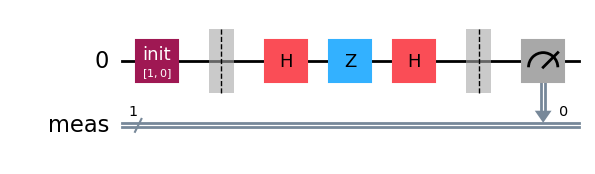

In [3]:
from qiskit import QuantumCircuit

a = qis.QuantumRegister(1, name = '0')

circuit = qis.QuantumCircuit(a) #generate a circuit with one qubit

init_gate = qis.circuit.library.Initialize([1, 0])
init_gate.label = "init"

circuit.append(init_gate, [0])
circuit.barrier()

circuit.h(a)    #add gates in the folowing order: 
circuit.z(a)    #Hadamard gate, T gate, Hadamard gate, T gate, and finally a Z gate
circuit.h(a)
 
end = circuit.measure_all()

circuit.draw('mpl')


{'1': 1}


<IPython.core.display.Latex object>

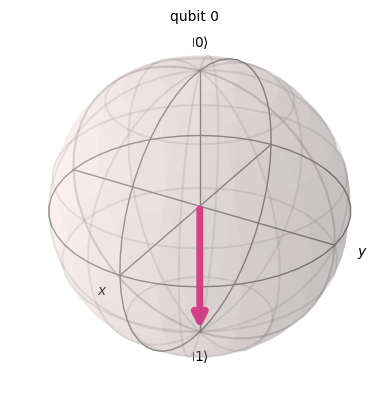

In [4]:
sim = AerSimulator(method="statevector")
N_shots = 1  # number of measurements

t_circ = qis.transpile(circuit, sim)
t_circ.save_statevector()  # save statevector at the end of the circuit
state = sim.run(t_circ, shots=N_shots).result().get_statevector()
result = sim.run(t_circ, shots=N_shots).result()
counts = result.get_counts(t_circ)

print(counts)

# draw using latex
# Display it nicely
display(array_to_latex(state, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(state)

We see that after applying the gates, the state of the qubit is now $\ket{1}$. This is the same result as we have got by the simple &\textit{evolve}$ function, the only difference is the numerical solution, we must have a measurement at the end ot the circuit to produce some result. Sometimes it is convenient to depict a measurement as a gate that takes a qubit as input and outputs a classical bit (as opposed to outputting the qubit in its post-measurement state and writing the result to a separate classical bit). This means the measured qubit has been discarded and can safely be ignored thereafter.

Also it is worth noting that quantum circuits are read from left to rigth, so the leftmost gate is applied first, then the second etc. This is in contrast to the bra-ket notation where the rightmost unitary is applied first. 

It is also worth mentioning that quantum circuits can be easily extended to include multiple qubits and multiple qubit gates. All multi-qubit-gates representing unitary operations can be decomposed into smaller, one and two qubit gates. There are certain sets of gates called $\textit{universal set}$. A set of universal quantum gates is any set of gates to which any operation possible on a quantum computer can be reduced, that is, any other unitary operation can be expressed as a finite sequence of gates from the set.

Possible sets are:
-   Rotation operators ( $R_x(\Theta)$, $R_y(\Theta)$, $R_z(\Theta)$ ), the phase shift ($P(\phi)$) and the CNOT gate
-   Clifford set (CNOT, H, S) and the T gate
-   Toffoli gate and the Hadamard gate

Before we carry on with the multi-qubit-circuits, let me show some of these two-qubit-gates as per their definition:
-   Controlled-NOT gate (CNOT)
    \begin{equation}
        CNOT_{ab} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \end{pmatrix}
    \end{equation}
    takes qubit $\textit{a}$ as the input and acts on $\textit{b}$ as $\hat{X} \ket{b}$.
-   SWAP gate:
    \begin{equation}
        SWAP = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{pmatrix}
    \end{equation}

During woring with the basic quantum circuits these will be the two-qubit-gates we will see.

Now to see them in action, for example, a two-qubit quantum circuit can be used to create a Bell state, which is a basis state for all of our computations with entanglement. 

Let me show the entanglement between two qubits in a simple quantum circuit.

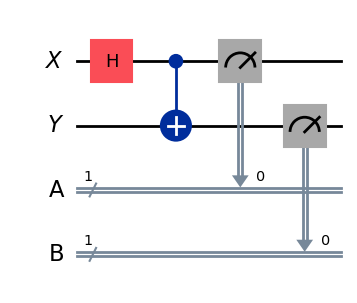

In [5]:
X = qis.QuantumRegister(1, "X")
Y = qis.QuantumRegister(1, "Y")
A = qis.ClassicalRegister(1, "A")
B = qis.ClassicalRegister(1, "B")

circuit = QuantumCircuit(X, Y, A, B)
circuit.h(X)
circuit.cx(X, Y)

circuit.measure(X, A)
circuit.measure(Y, B)

display(circuit.draw('mpl'))

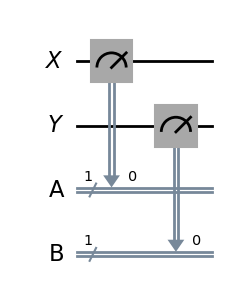

In [6]:
X = qis.QuantumRegister(1, "X")
Y = qis.QuantumRegister(1, "Y")
A = qis.ClassicalRegister(1, "A")
B = qis.ClassicalRegister(1, "B")

circuit1 = QuantumCircuit(X, Y, A, B)

circuit1.measure(X, A)
circuit1.measure(Y, B)

display(circuit1.draw('mpl'))

C:\Users\Botond\AppData\Local\Temp\ipykernel_21972\3688300367.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  results = Sampler().run(circuit).result()
C:\Users\Botond\AppData\Local\Temp\ipykernel_21972\3688300367.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  results1 = Sampler().run(circuit1).result()


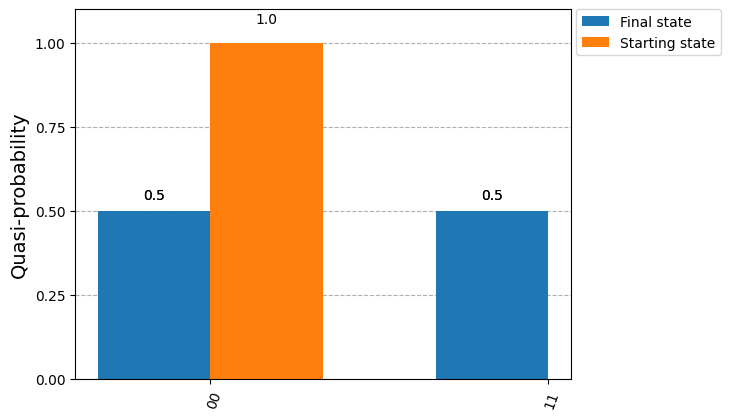

In [10]:
results = Sampler().run(circuit).result()
statistics = results.quasi_dists[0].binary_probabilities()

results1 = Sampler().run(circuit1).result()
statistics1 = results1.quasi_dists[0].binary_probabilities()

legend = ['Final state', 'Starting state']
display(plot_histogram([statistics, statistics1], legend=legend))

We see that after applying the gates, the state of the qubits is now entangled. A gate wise calculation would be:

\begin{equation}
    (CNOT_{01} H)\ket{00} = (CNOT_{01})\ket{+0} = (CNOT_{01})(\frac{\ket{00} + \ket{01}}{\sqrt{2}}) = \frac{\ket{00} + \ket{11}}{\sqrt{2}} = \ket{\Phi^+}
\end{equation}

The qiskit algorithm will start with the states being in $\ket{00}$, but of corse it can be easily overwritten with a simple algorithm (seen below). A natural question could arise wether the circuit seen just before could generate entangled states from other basis states of a two-qubit-system, and the answer is yes, as shown:

\begin{split}
    U\ket{00} = \frac{\ket{00} + \ket{11}}{\sqrt{2}} = \ket{\Phi^+}
    \\
    U\ket{01} = \frac{\ket{00} - \ket{11}}{\sqrt{2}} = \ket{\Phi^-}
    \\
    U\ket{10} = \frac{\ket{01} + \ket{10}}{\sqrt{2}} = \ket{\Psi^+}
    \\
    U\ket{11} = \frac{\ket{01} - \ket{10}}{\sqrt{2}} = \ket{\Psi^-}
\end{split} 
where $\textit{U}$ means the gates applied, the Hadamard and then the control-NOT.

As stated previously; as entangled states cannot be written as a product of basis states, measuring either system (A or B) will have an effect on the other, and measurement collapses the system's state vector to one of the entangled basis states. This is known as the measurement problem in quantum mechanics. So how is this measurement problem useful for us?

Alice and Bob are names traditionally given to hypothetical entities or agents in systems, protocols, games, and other interactions that involve the exchange of information. By default, we imagine that Alice and Bob are in different locations. They may have different goals and behaviors depending on the context in which they arise. For example, in communication, meaning the transmission of information, we might decide to use the name Alice to refer to the sender and Bob to refer to the receiver of whatever information is transmitted. Other names that represent different personas, such as Eve for an eavesdropper or Mallory for someone behaving maliciously, are also sometimes used. 

They (Alice and Bob) will use entanglement as a resource that allows them to communicate securely, even if they are separated by vast distances.
Indeed, it is typical in the study of quantum information and computation that entanglement is viewed as a resource through which different tasks can be accomplished. When this is done, the state $\ket{\Phi^+}$ is a state of maximum entanglement between Alice and Bob's qubits and is viewed as representing one unit of entanglement, which we refer to as an e-bit.

Quantum teleportation, or just teleportation for short, is a protocol where a sender (Alice) transmits a qubit to a receiver (Bob) by making use of a shared entangled quantum state (one e-bit, to be specific) along with two bits of classical communication. The name teleportation is meant to be suggestive of the concept in science fiction where matter is transported from one location to another by a futuristic process, but it must be understood that matter is not teleported in quantum teleportation — what is actually teleported is quantum information.

The set-up for teleportation is as follows. They hold the qubits A and B seperately, but in the same location, and act on them to create an entangled state of $\ket{\Phi^+}_{AB}$ (entanglement cannot be created locally i.e. Alice and Bob acting on the qubits separately, they need to be together before they can split up). Then Alice takes posession of qubit M; $\ket{\phi}_M = \alpha \ket{0} + \beta \ket{1}$ (normalised state). This is the state she wants to transmit (or teleport) to Bob via their shared entangled state.

In [7]:
def teleport(Statevector):
    # define quantum and classical channels
    m = qis.QuantumRegister(1, name = 'M')
    a = qis.QuantumRegister(1, name = 'A')
    b = qis.QuantumRegister(1, name = 'B')
    c = qis.ClassicalRegister(3, name = 'Register') # classical register to store the measurement outcome
    circ = qis.QuantumCircuit(m, a, b, c) 
    
    #define the initialization of the qubit that we want to tp
    init_gate = qis.circuit.library.Initialize(Statevector)
    init_gate.label = "init"
    # and also the inverse for later uses
    inverse_init_gate = init_gate.gates_to_uncompute()

    circ.append(init_gate, [0])
    circ.barrier()
    
    # entangling Alice and Bob
    circ.h(a)
    circ.cx(a, b)
    circ.barrier() # visual barrier

    # Performing bell measurement on the MA state
    circ.cx(m, a)
    circ.h(m)

    circ.measure(a, c[0]) # measure qubit a and store the result in c
    circ.measure(m, c[1]) # measure qubit m and store the result in c
    
    circ.x(b).c_if(c[0], 1)
    circ.z(b).c_if(c[1], 1)
    
    #circ.append(inverse_init_gate, [2])
    #circ.measure(b, c[2])

    #circ.x(b).c_if(c[0], 1)
    #circ.z(b).c_if(c[1], 1)

    #circ.measure(b, c[2]) # measure qubit b and store the result in c, hopefully getting the result we need
    return circ


In [8]:
tel_state = qis.quantum_info.random_statevector(2, seed=None)

<IPython.core.display.Latex object>

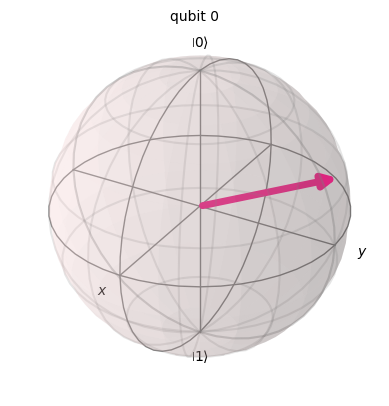

In [9]:
# Display it nicely
display(array_to_latex(tel_state, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(tel_state)

C:\Users\Botond\AppData\Local\Temp\ipykernel_19196\3729270637.py:30: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circ.x(b).c_if(c[0], 1)
C:\Users\Botond\AppData\Local\Temp\ipykernel_19196\3729270637.py:31: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  circ.z(b).c_if(c[1], 1)


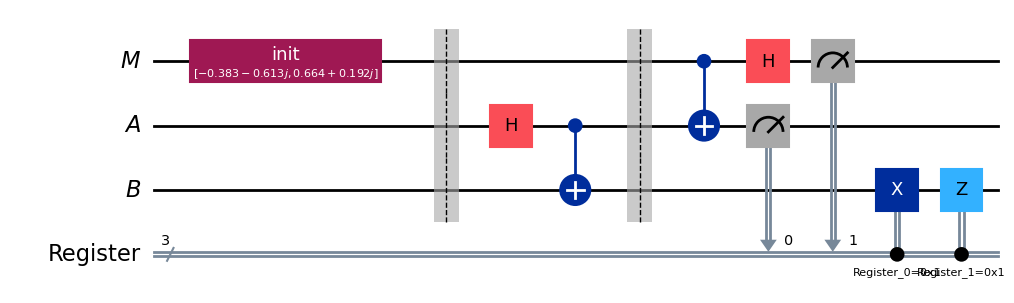

In [10]:
circ = teleport(tel_state)
circ.draw('mpl')


{'000': 222, '010': 258, '011': 265, '001': 255}


<IPython.core.display.Latex object>

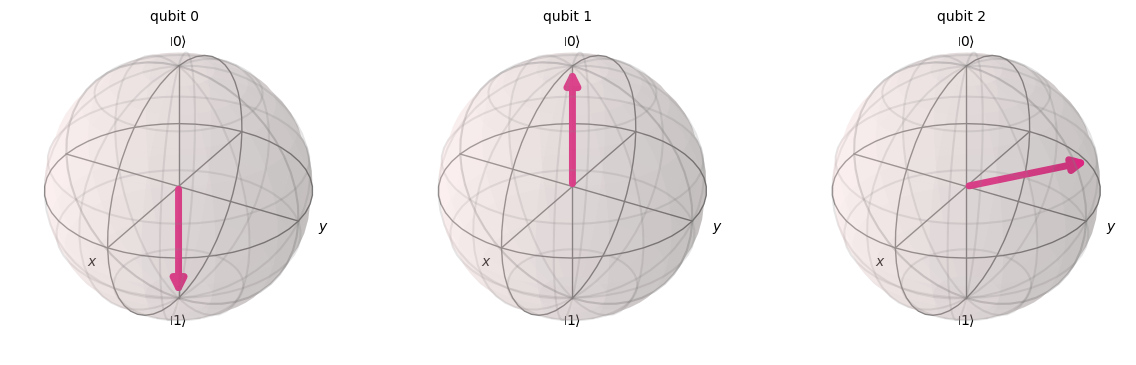

In [11]:
# initialize the simulator in the "statevector" mode to simulate full wave function
sim = AerSimulator(method="statevector")
N_shots = 1000  # number of measurements

t_circ = qis.transpile(circ, sim)
t_circ.save_statevector()  # save statevector at the end of the circuit
state = sim.run(t_circ, shots=N_shots).result().get_statevector()
result = sim.run(t_circ, shots=N_shots).result()
counts = result.get_counts()

print(counts)

# draw using latex
# Display it nicely
display(array_to_latex(state, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(state)

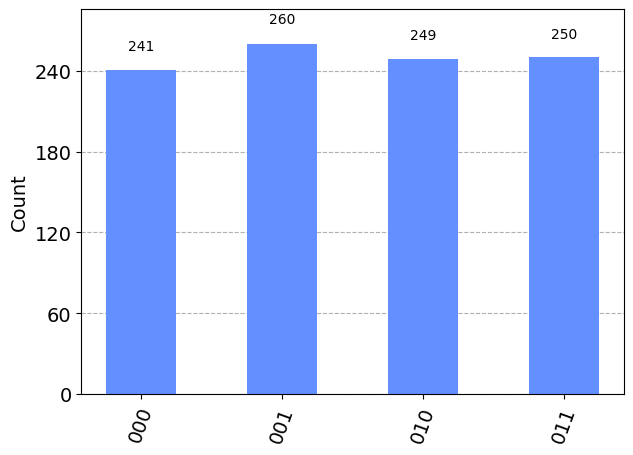

In [37]:
qis.visualization.plot_histogram(counts)

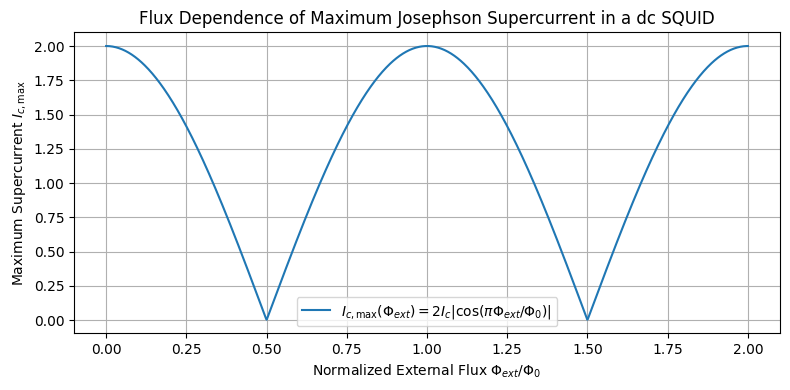

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
phi0 = 1.0  # Flux quantum (normalized)
phi_ext = np.linspace(0, 2 * phi0, 1000)  # External flux range

# Maximum supercurrent through a symmetric dc SQUID
# I_c_max(phi) = 2 * I_c * |cos(pi * phi_ext / phi0)|
I_c = 1.0  # Critical current of each junction (normalized)
I_c_max = 2 * I_c * np.abs(np.cos(np.pi * phi_ext / phi0))

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(phi_ext / phi0, I_c_max, label=r"$I_{c,\mathrm{max}}(\Phi_{ext}) = 2 I_c |\cos(\pi \Phi_{ext}/\Phi_0)|$")
plt.xlabel(r"Normalized External Flux $\Phi_{ext}/\Phi_0$")
plt.ylabel(r"Maximum Supercurrent $I_{c,\mathrm{max}}$")
plt.title("Flux Dependence of Maximum Josephson Supercurrent in a dc SQUID")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
